# 프로젝트 : Segmentation map으로 도로 이미지 만들기🛣️🖼️

In [ ]:
import os
import time
import cv2
import numpy as np
import tensorflow as tf

from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as image
from IPython import display

## Conditional Generative Adversarial Nets(cGAN)
cGAN은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법입니다.
## GAN과 cGAN의 목적함수
GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전합니다. 이를 아래와 같은 식으로 나타낼 수 있으며 Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습합니다.
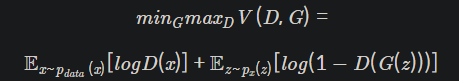

cGAN의 목적함수는 아래와 같습니다.

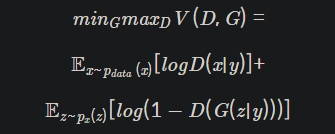

D(x)와 G(z)가 각각 D(x∣y), G(z∣y)로 바뀌었다는 차이가 있습니다.
여기서 함께 입력하는 yy는 어떠한 정보여도 상관없으며, MNIST 데이터셋을 학습시키는 경우 yy는 0~9 까지의 label 정보가 됩니다.
Generator가 어떠한 노이즈 zz를 입력받았을 때, 특정 조건 yy가 함께 입력되기 때문에, yy를 통해 zz를 어떠한 이미지로 만들어야 할지에 대한 방향을 제어할 수 있게 됩니다.
조금 다르게 표현하면 yy가 임의 노이즈 입력인 zz의 가이드라고 할 수 있겠죠.

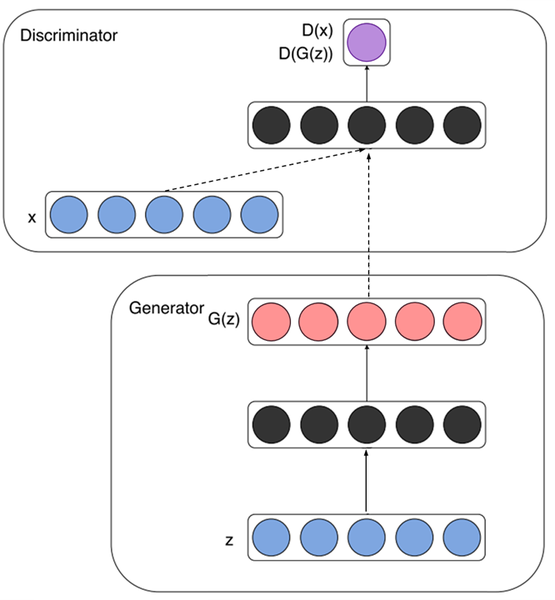

GAN의 학습 과정은 위 그림과 같습니다.

* Generator :
노이즈 zz(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 G(z)G(z) (빨간색)를 생성해 냅니다.
* Discriminator :
실제 데이터 xx와 Generator가 생성한 가짜 데이터 G(z)G(z)를 각각 입력받아 D(x)D(x) 및 D(G(z))D(G(z)) (보라색)를 계산하여 진짜와 가짜를 식별해 냅니다.

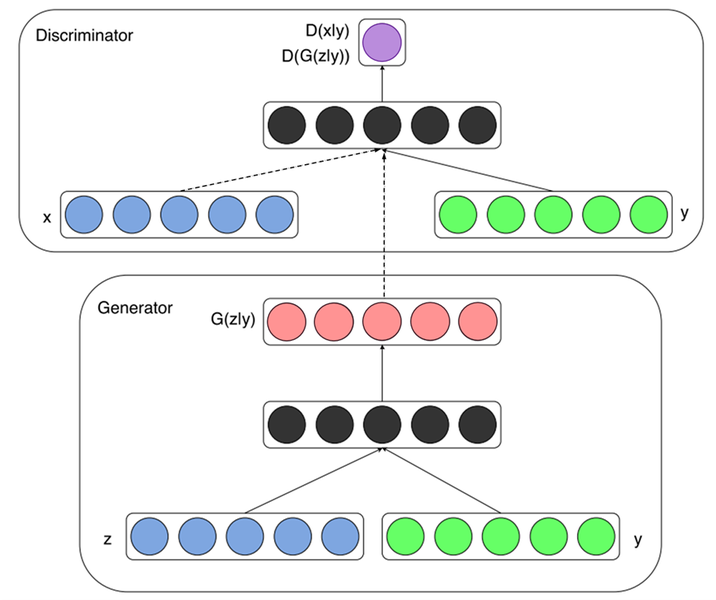

이전 목적함수에서 확인했듯이, cGAN에서 바뀐 부분은 yy라는 정보가 함께 입력된다는 것입니다.

* Generator : 노이즈 zz(파란색)와 추가 정보 yy(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 G(z∣y)G(z∣y)를 생성합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 yy는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣습니다.
* Discriminator : 실제 데이터 xx와 Generator가 생성한 가짜 데이터 G(z∣y)G(z∣y)를 각각 입력받으며, 마찬가지로 yy정보가 각각 함께 입력되어 진짜와 가짜를 식별합니다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 xx와 yy는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 yy와 Discriminator에 입력되는 yy는 동일한 레이블을 나타내야 합니다.

## 데이터 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/aiffel/exp17_conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [ ]:
data_path2 = '/content/drive/MyDrive/aiffel/exp17_conditional_generation/cityscapes/val/'
print("number of val examples :", len(os.listdir(data_path2)))

number of val examples : 5


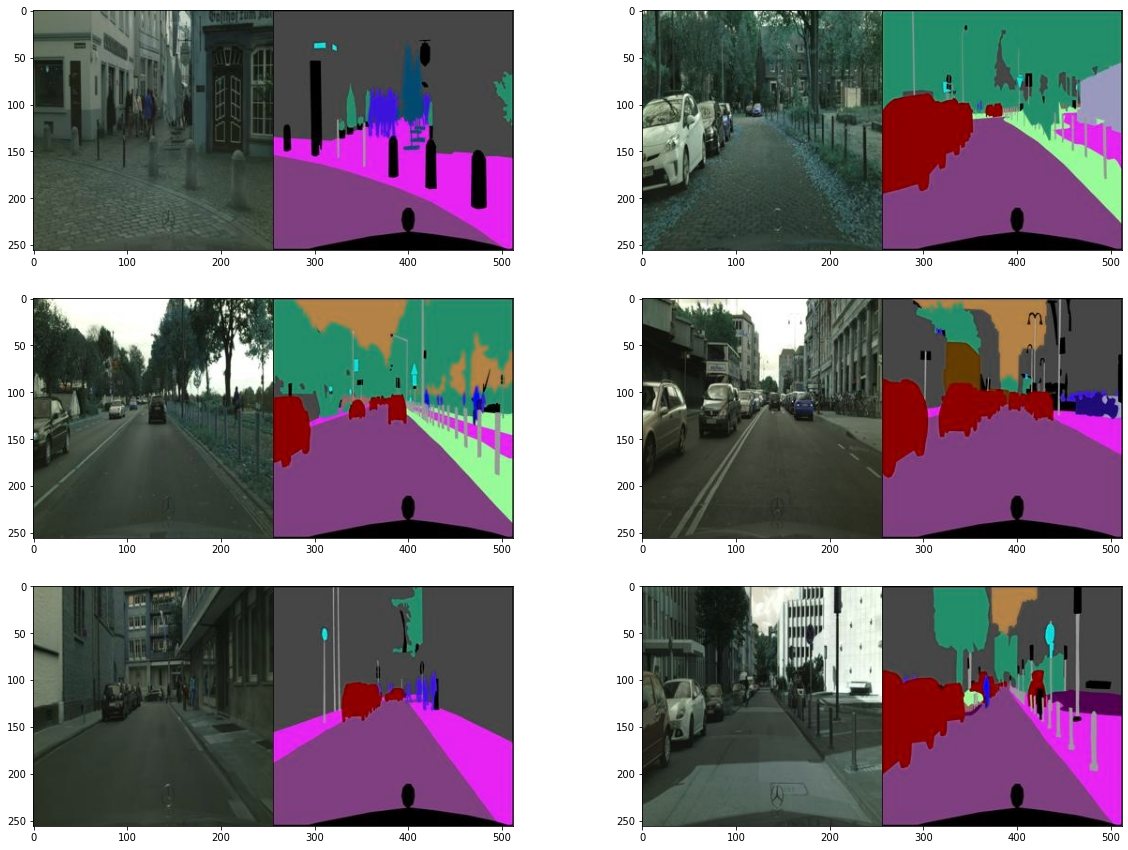

In [ ]:
# 이미지 살펴보기
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
# 이미지 크기
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


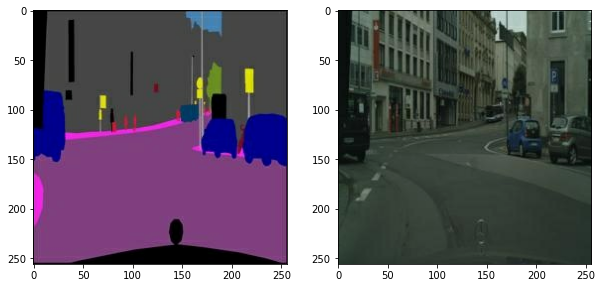

In [ ]:
# 이미지를 2개로 분할
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_img = img[:, :w, :] 
    real_img = tf.cast(real_img, tf.float32)
    input_img = img[:, w:, :] 
    input_img = tf.cast(input_img, tf.float32)
    return normalize(input_img), normalize(real_img)

f = data_path + os.listdir(data_path)[1]
input_img, real_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

## 데이터 Augmentation
* 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.
* 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)
* 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)
* 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)
* 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)
* 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(input_img, real_img):
    stacked = tf.concat([input_img, real_img], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


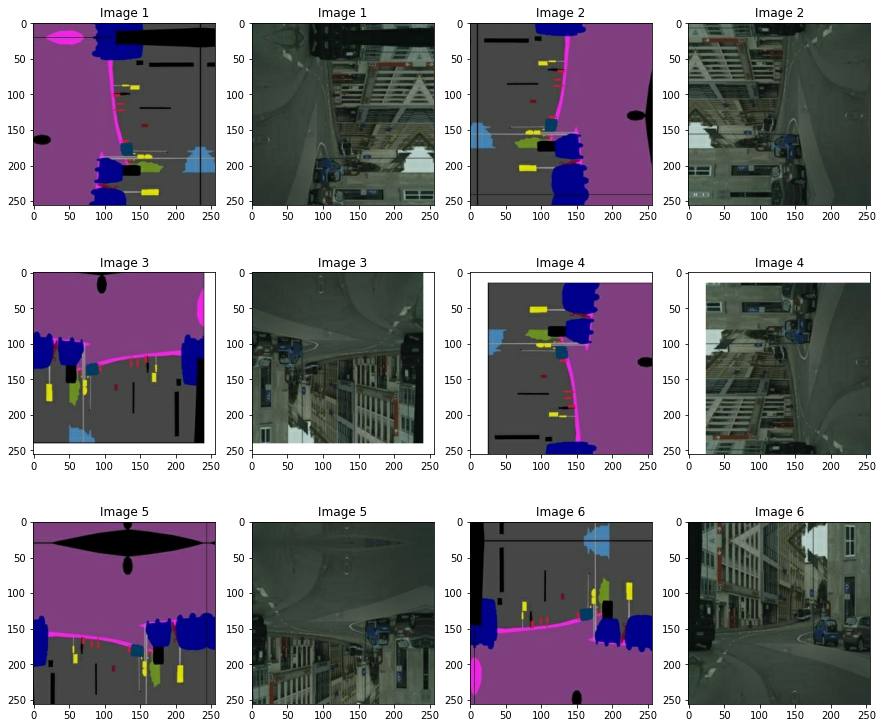

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_img, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

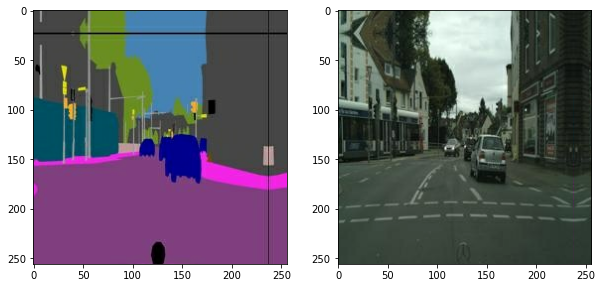

In [ ]:
from tensorflow import data

def get_train(img_path):
    input_img, real_img = load_img(img_path)
    input_img, real_img = apply_augmentation(input_img, real_img)
    return input_img, real_img

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_img, real_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))

## Generator
* Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용
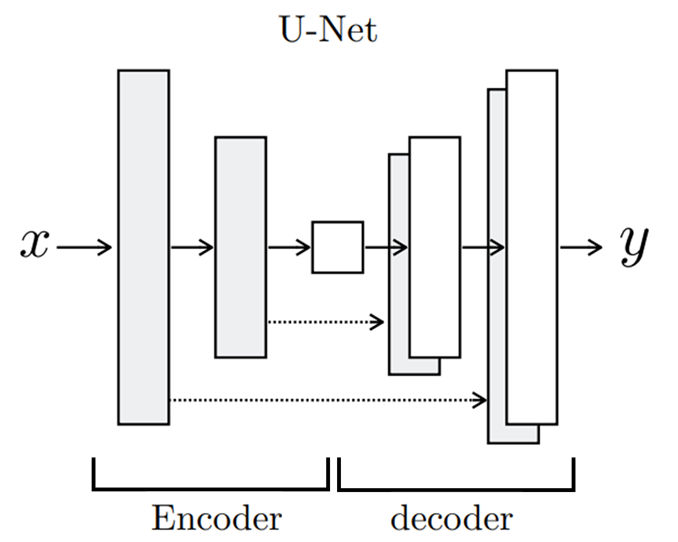

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

## Discriminator

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_15 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [ ]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

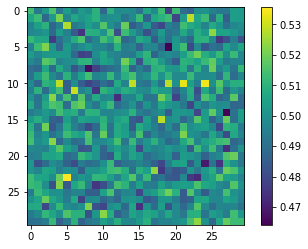

In [ ]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 모델 학습

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [ ]:
@tf.function
def train_step(input_img, real_img):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_img, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_img, gen_output, training=True)
        real_disc = discriminator(input_img, real_img, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, real_img, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_img, real_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_img, real_img)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:0.9735                     
L1_loss:0.1746                     
Discriminator_loss:1.0758

EPOCH[2] - STEP[200]                     
Generator_loss:2.8680                     
L1_loss:0.1797                     
Discriminator_loss:0.6891

EPOCH[3] - STEP[200]                     
Generator_loss:2.2999                     
L1_loss:0.1839                     
Discriminator_loss:0.3372

EPOCH[4] - STEP[200]                     
Generator_loss:1.0016                     
L1_loss:0.2199                     
Discriminator_loss:1.1134

EPOCH[5] - STEP[200]                     
Generator_loss:0.6601                     
L1_loss:0.1912                     
Discriminator_loss:1.0927



## 학습 결과 확인

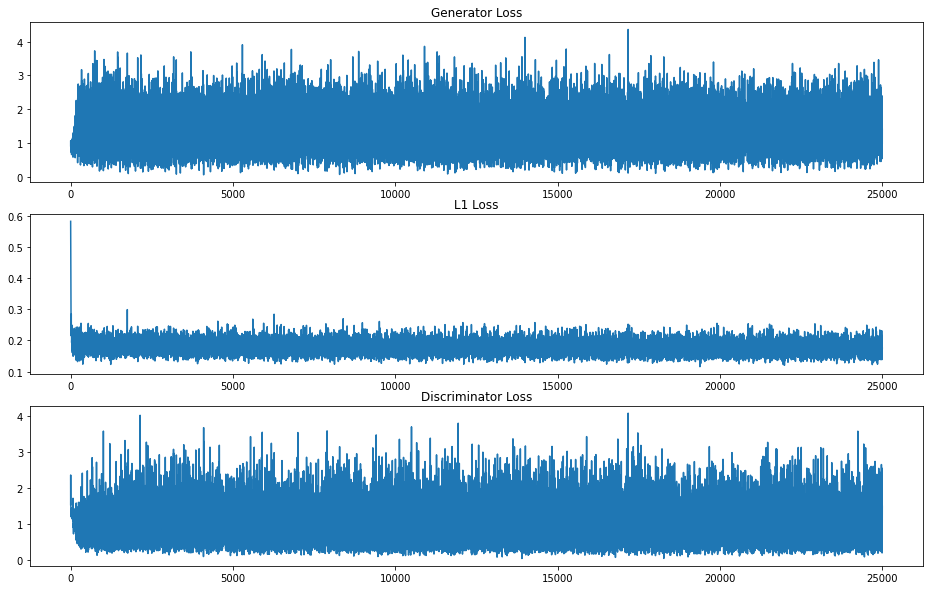

In [ ]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

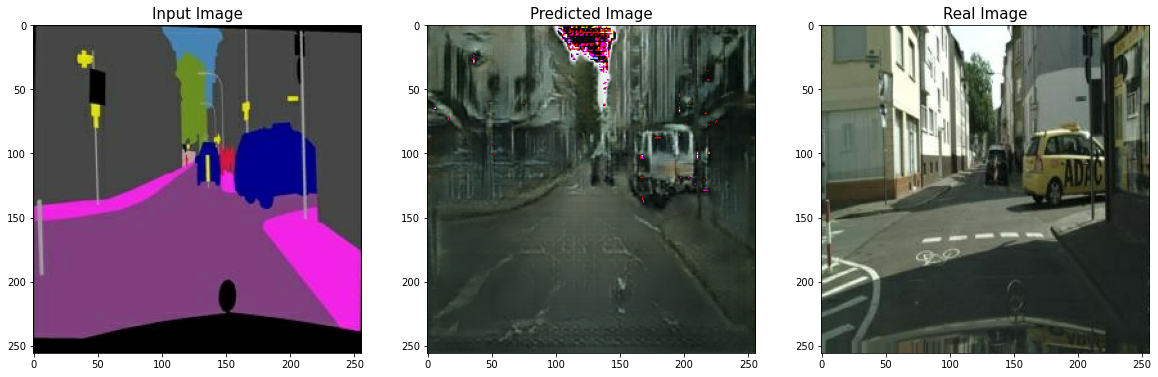

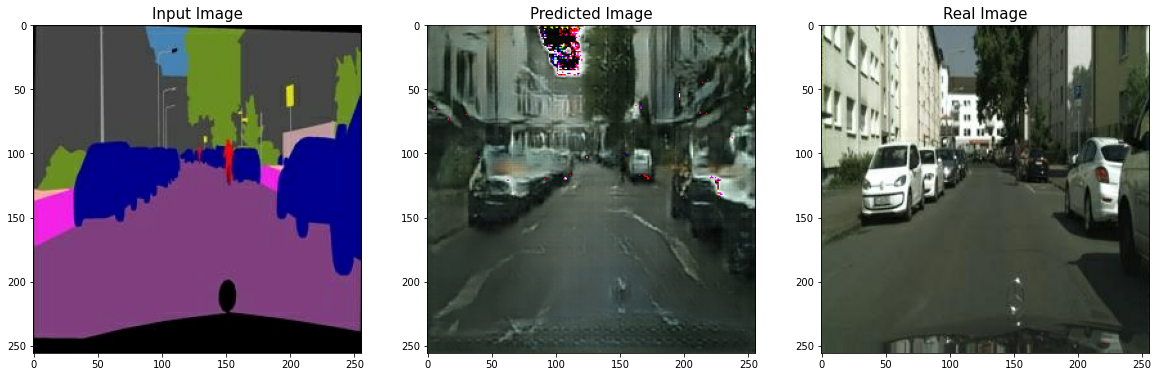

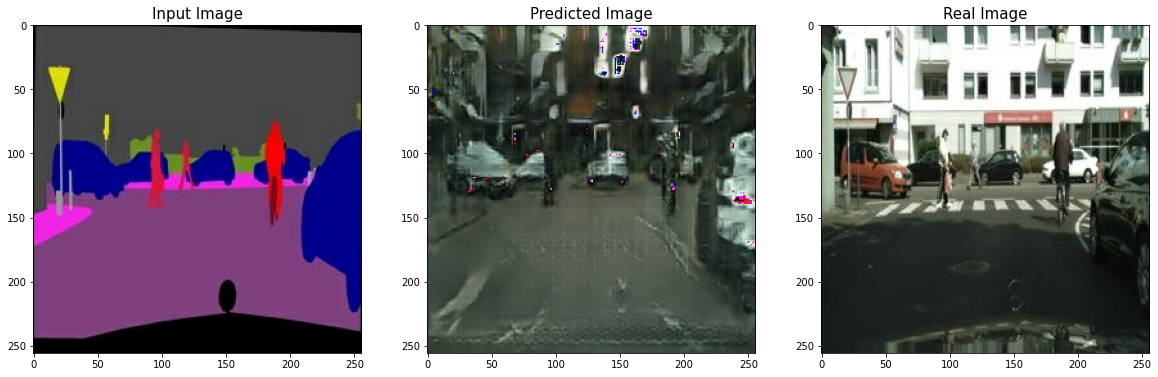

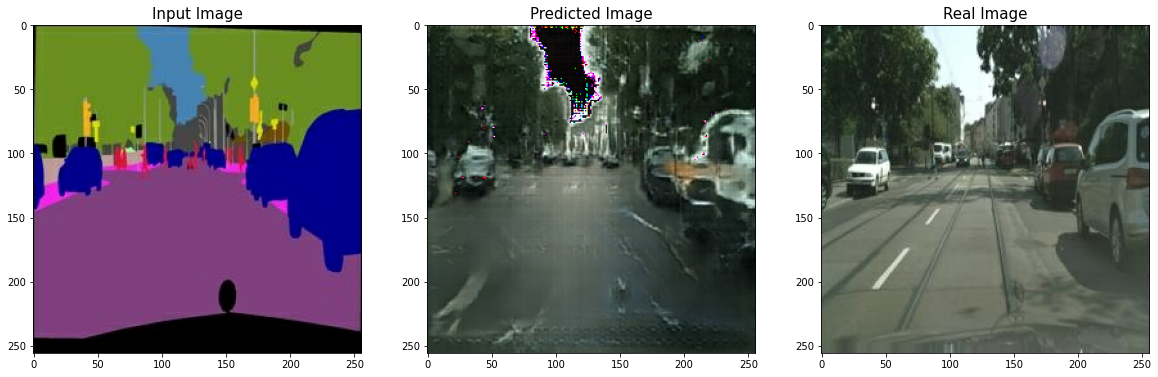

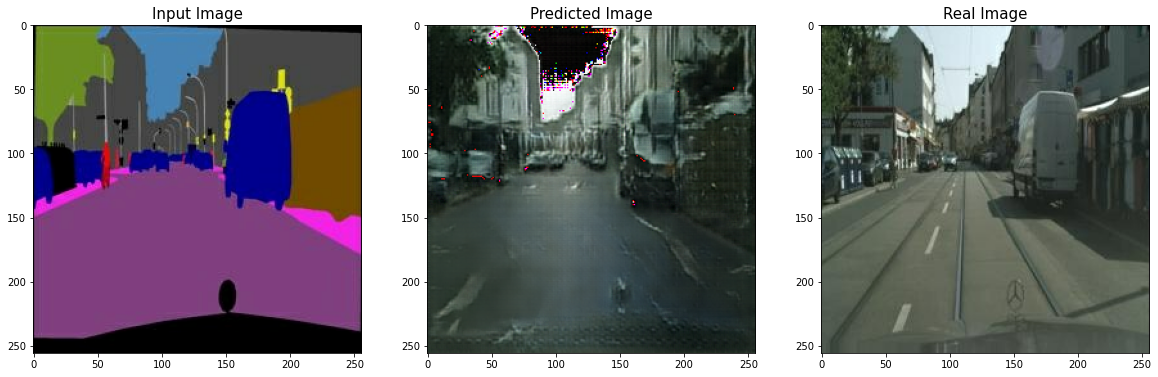

In [ ]:
test_path = '/content/drive/MyDrive/aiffel/exp17_conditional_generation/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_img, real_img = load_img(f)

    pred = generator(tf.expand_dims(input_img, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_img)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=15)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_img)); plt.title('Real Image', fontsize=15)

## Epoch 늘려서 학습

In [ ]:
EPOCHS = 400

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}

for epoch in range(1, EPOCHS+1):
    for i, (input_img, real_img) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_img, real_img)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)
        
        # 반복마다 손실을 출력합니다.
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:1.5910                     
L1_loss:0.1500                     
Discriminator_loss:0.8874

EPOCH[2] - STEP[200]                     
Generator_loss:1.5861                     
L1_loss:0.1818                     
Discriminator_loss:0.4660

EPOCH[3] - STEP[200]                     
Generator_loss:0.7423                     
L1_loss:0.2063                     
Discriminator_loss:0.7896

EPOCH[4] - STEP[200]                     
Generator_loss:1.5502                     
L1_loss:0.1761                     
Discriminator_loss:0.4877

EPOCH[5] - STEP[200]                     
Generator_loss:0.9681                     
L1_loss:0.1682                     
Discriminator_loss:0.8250

EPOCH[6] - STEP[200]                     
Generator_loss:1.1885                     
L1_loss:0.1770                     
Discriminator_loss:0.6839

EPOCH[7] - STEP[200]                     
Generator_loss:0.4493                     
L1_loss:0.1840             

## 결과 확인

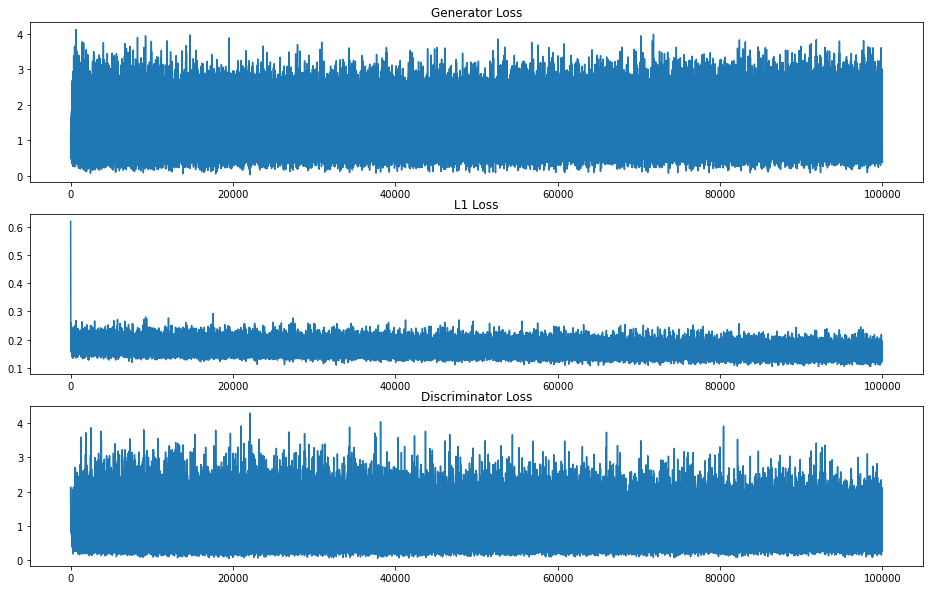

In [ ]:
plt.figure(figsize=(16,10))

plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.show()

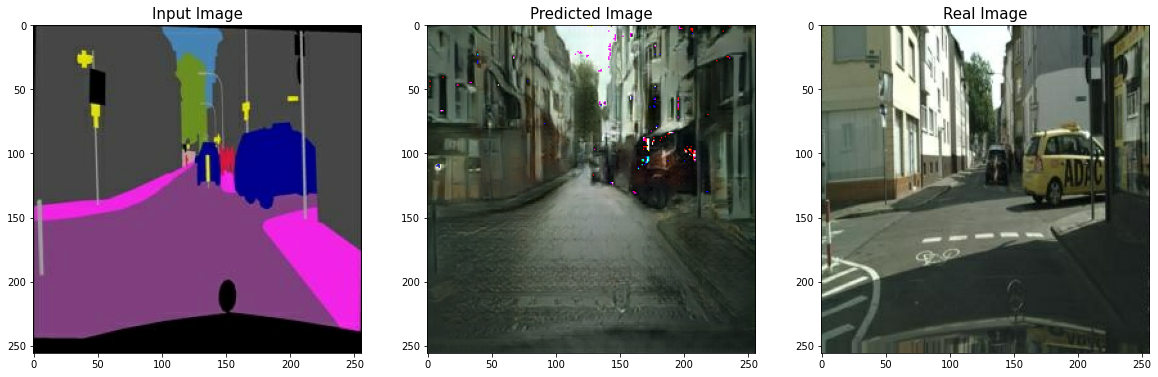

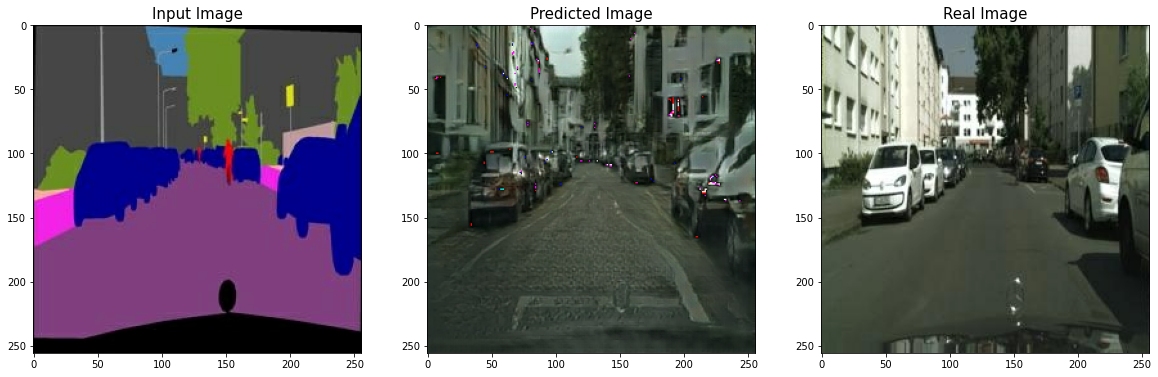

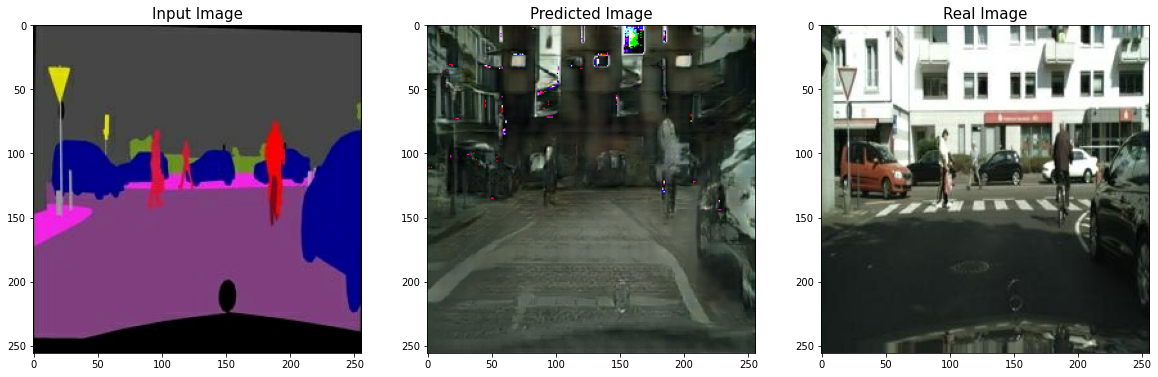

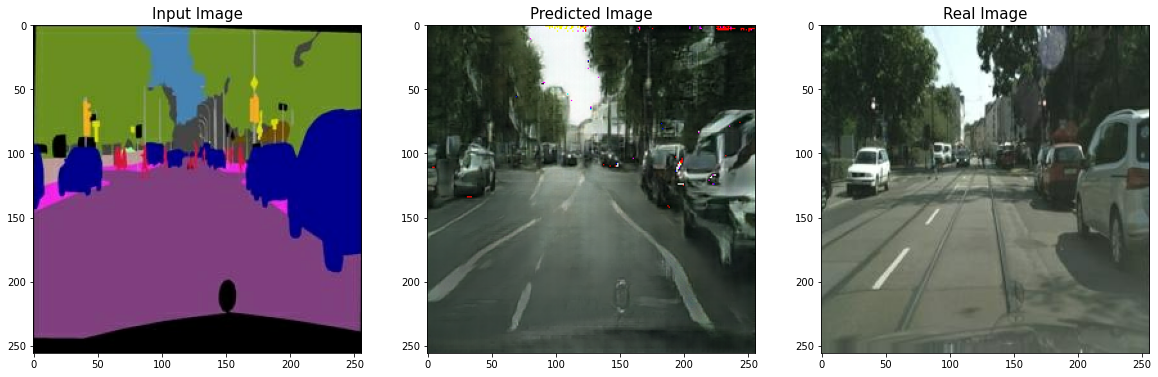

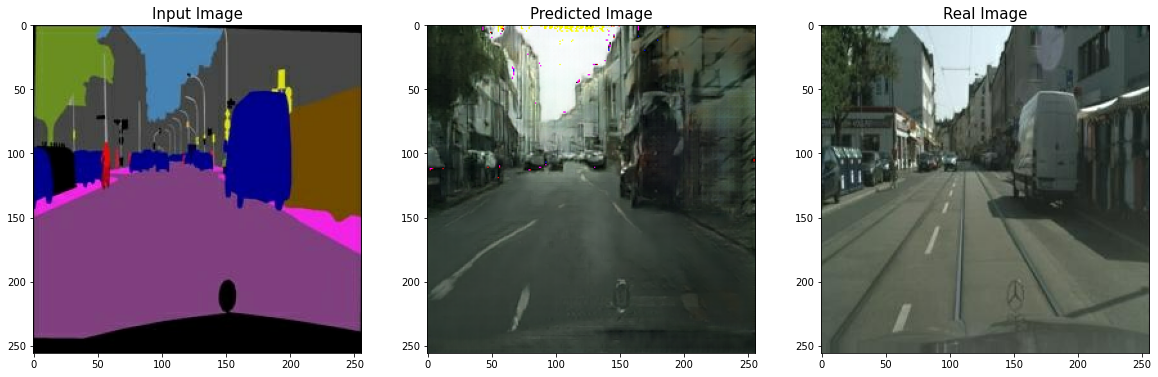

In [ ]:
test_path = '/content/drive/MyDrive/aiffel/exp17_conditional_generation/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_img, real_img = load_img(f)

    pred = generator(tf.expand_dims(input_img, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_img)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=15)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_img)); plt.title('Real Image', fontsize=15)

# 회고
* GAN 모델의 Generator, Discriminator, cGAN, Pix2Pix에 대해 개념확립과 실습을 해볼 수 있어서 좋았다.
* 100epoch와 400epoch모델의 차이는 일그러짐과 건물 디테일인 것 같다. 몇 epoch를 돌려야 Ground Truth와 차이가 없는 이미지가 나올 지 궁금하다. 